# 2018 Yellow Taxi Trip Data Analysis

- Read taxi-sample and shape files
- Data cleaning (removing null values, trip duration 0 etc.)

In [1]:
import pandas as pd
import numpy as np
import time
import shapefile
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from descartes.patch import PolygonPatch
import seaborn as sns
import math

In [2]:
startTime = time.time()
taxiSample = pd.read_csv("data/taxi-sample.csv")
taxiSample[105:110]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
105,2,03/12/2019 11:12:48 PM,03/12/2019 11:23:38 PM,1,1.10,1,N,137,113,1,8.5,0.0,0.5,1.86,0.0,0.3,11.16
106,2,03/07/2019 06:25:03 AM,03/07/2019 03:25:31 PM,1,8.66,1,N,163,54,1,38.0,0.0,0.5,7.76,0.0,0.3,46.56
107,2,03/04/2019 12:35:59 PM,03/04/2019 01:07:03 PM,2,5.52,1,N,50,179,1,23.0,0.0,0.5,0.00,0.0,0.3,23.80
108,2,03/04/2019 12:13:56 AM,03/04/2019 12:32:39 AM,5,11.94,1,N,70,265,2,32.5,0.0,0.5,0.00,0.0,0.3,33.30
109,2,03/03/2019 03:27:20 AM,03/03/2019 12:01:14 PM,1,6.37,1,N,170,13,1,27.0,0.0,0.5,4.50,0.0,0.3,32.30


In [3]:
%%time
taxiSample['tpep_pickup_datetime'] = pd.to_datetime(taxiSample['tpep_pickup_datetime'], format='%m/%d/%Y %I:%M:%S %p')
taxiSample['tpep_dropoff_datetime'] = pd.to_datetime(taxiSample['tpep_dropoff_datetime'], format='%m/%d/%Y %I:%M:%S %p')

CPU times: user 7.4 s, sys: 48.6 ms, total: 7.45 s
Wall time: 7.49 s


In [4]:
taxiSample["pickup_weekday"] = taxiSample.tpep_pickup_datetime.dt.weekday_name
taxiSample["pickup_hour"] = taxiSample.tpep_pickup_datetime.dt.hour
taxiSample["pickup_month"] = taxiSample.tpep_pickup_datetime.dt.month
taxiSample["pickup_year"] = taxiSample.tpep_pickup_datetime.dt.year

In [5]:
taxiSample["dropoff_weekday"] = taxiSample.tpep_dropoff_datetime.dt.weekday_name
taxiSample["dropoff_hour"] = taxiSample.tpep_dropoff_datetime.dt.hour
taxiSample["dropoff_month"] = taxiSample.tpep_dropoff_datetime.dt.month
taxiSample["dropoff_year"] = taxiSample.tpep_dropoff_datetime.dt.year

In [6]:
taxiSample[105:110]

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,improvement_surcharge,total_amount,pickup_weekday,pickup_hour,pickup_month,pickup_year,dropoff_weekday,dropoff_hour,dropoff_month,dropoff_year
105,2,2019-03-12 23:12:48,2019-03-12 23:23:38,1,1.10,1,N,137,113,1,...,0.3,11.16,Tuesday,23,3,2019,Tuesday,23,3,2019
106,2,2019-03-07 06:25:03,2019-03-07 15:25:31,1,8.66,1,N,163,54,1,...,0.3,46.56,Thursday,6,3,2019,Thursday,15,3,2019
107,2,2019-03-04 12:35:59,2019-03-04 13:07:03,2,5.52,1,N,50,179,1,...,0.3,23.80,Monday,12,3,2019,Monday,13,3,2019
108,2,2019-03-04 00:13:56,2019-03-04 00:32:39,5,11.94,1,N,70,265,2,...,0.3,33.30,Monday,0,3,2019,Monday,0,3,2019
109,2,2019-03-03 03:27:20,2019-03-03 12:01:14,1,6.37,1,N,170,13,1,...,0.3,32.30,Sunday,3,3,2019,Sunday,12,3,2019


In [7]:
print(taxiSample.shape)

(1048576, 25)


## Data Cleaning

### Checking if there is any null value in the dataset

In [8]:
taxiSample.isnull().any()

VendorID                 False
tpep_pickup_datetime     False
tpep_dropoff_datetime    False
passenger_count          False
trip_distance            False
RatecodeID               False
store_and_fwd_flag       False
PULocationID             False
DOLocationID             False
payment_type             False
fare_amount              False
extra                    False
mta_tax                  False
tip_amount               False
tolls_amount             False
improvement_surcharge    False
total_amount             False
pickup_weekday           False
pickup_hour              False
pickup_month             False
pickup_year              False
dropoff_weekday          False
dropoff_hour             False
dropoff_month            False
dropoff_year             False
dtype: bool

### Removing rows with trip distance 0 or less

In [9]:
trip_dist = taxiSample[taxiSample.trip_distance <= 0.0]
trip_dist.shape

(8463, 25)

In [10]:
taxiSample = taxiSample[taxiSample.trip_distance > 0.0]
taxiSample.shape

(1040113, 25)

### Removing rows with passenger count 0 or less

In [11]:
pass_count = taxiSample[taxiSample.passenger_count <= 0]
pass_count.shape

(15039, 25)

In [12]:
taxiSample = taxiSample[taxiSample.passenger_count > 0]
taxiSample.shape

(1025074, 25)

### Removing duplicate rows

In [13]:
duplicate = taxiSample[taxiSample.duplicated()]
duplicate.shape

(21, 25)

In [14]:
taxiSample.drop_duplicates(keep='first', inplace=True)
taxiSample.shape

(1025053, 25)

### Removing rows with same pickup and dropoff time

In [15]:
same_pick_drop = taxiSample[taxiSample.tpep_pickup_datetime==taxiSample.tpep_dropoff_datetime]
same_pick_drop.shape

(46, 25)

In [16]:
taxiSample = taxiSample[taxiSample.tpep_pickup_datetime!=taxiSample.tpep_dropoff_datetime]
taxiSample.shape

(1025007, 25)

### Removing rows with future dates

In [17]:
print("Train dataset start date: ", min(taxiSample["tpep_pickup_datetime"]))
print("Train dataset end date: ", max(taxiSample["tpep_dropoff_datetime"]))

Train dataset start date:  2018-12-27 00:05:14
Train dataset end date:  2084-11-04 12:47:41


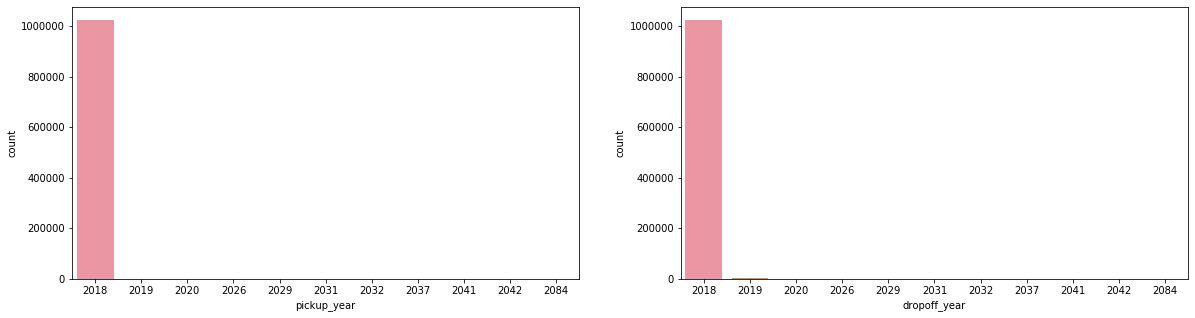

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.countplot(x='pickup_year', data=taxiSample, ax=ax[0])
sns.countplot(x='dropoff_year', data=taxiSample, ax=ax[1])
plt.show()

In [19]:
taxiSample.groupby('pickup_year')['pickup_year'].count()

pickup_year
2018    1024804
2019        175
2020         10
2026          2
2029          2
2031          2
2032          1
2037          1
2041          1
2042          1
2084          8
Name: pickup_year, dtype: int64

#### We are assuming limit for date is: "2019-06-30 23:59:59" and remove all the future dates

In [20]:
taxiSample = taxiSample[taxiSample.tpep_pickup_datetime<="2019-06-30 23:59:59"]
taxiSample.shape

(1024969, 25)

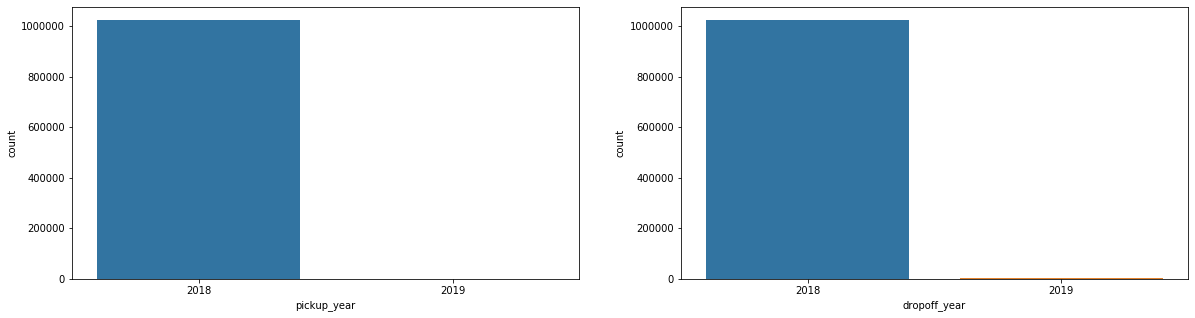

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.countplot(x='pickup_year', data=taxiSample, ax=ax[0])
sns.countplot(x='dropoff_year', data=taxiSample, ax=ax[1])
plt.show()

### Removing rows that have RatecodeID>6

In [22]:
ratecode_count = taxiSample.groupby('RatecodeID')['RatecodeID'].count()
ratecode_count

RatecodeID
1     991516
2      25862
3       1674
4        652
5       5253
6          2
99        10
Name: RatecodeID, dtype: int64

In [23]:
taxiSample = taxiSample[taxiSample.RatecodeID<=6]
taxiSample.shape

(1024959, 25)

### Checking amounts for negative or zero values

In [24]:
taxiSample[taxiSample.fare_amount<=0.0].shape

(1029, 25)

In [25]:
taxiSample[taxiSample.tip_amount<0.0].shape

(5, 25)

In [26]:
taxiSample[taxiSample.tolls_amount<0.0].shape

(17, 25)

In [27]:
taxiSample[taxiSample.total_amount<=0.0].shape

(902, 25)

In [28]:
taxiSample[taxiSample.extra<0.0].shape

(440, 25)

In [29]:
taxiSample[taxiSample.mta_tax<0.0].shape

(856, 25)

In [30]:
taxiSample[taxiSample.improvement_surcharge<0.0].shape

(871, 25)

In [31]:
taxiSample = taxiSample[taxiSample.fare_amount>0.0]
taxiSample = taxiSample[taxiSample.tip_amount>=0.0]
taxiSample = taxiSample[taxiSample.tolls_amount>=0.0]
taxiSample = taxiSample[taxiSample.total_amount>0.0]
taxiSample = taxiSample[taxiSample.extra>=0.0]
taxiSample = taxiSample[taxiSample.mta_tax>=0.0]
taxiSample = taxiSample[taxiSample.improvement_surcharge>=0.0]
taxiSample.shape

(1023929, 25)

### Removing rows that has LocationID > 263 or < 1, as we don't have shape for those zones

In [32]:
taxiSample[taxiSample.PULocationID>263].shape

(16443, 25)

In [33]:
taxiSample[taxiSample.DOLocationID>263].shape

(17072, 25)

In [34]:
taxiSample = taxiSample[taxiSample.PULocationID<=263]

In [35]:
taxiSample = taxiSample[taxiSample.DOLocationID<=263]

# Insights on different attributes

### Which vendor has the most data record?

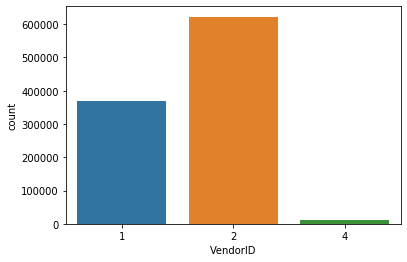

In [36]:
sns.countplot(x="VendorID", data=taxiSample)

In [37]:
taxiSample.groupby('VendorID')['VendorID'].count()

VendorID
1    370427
2    622408
4     12007
Name: VendorID, dtype: int64

### What is the most frequent passenger number?

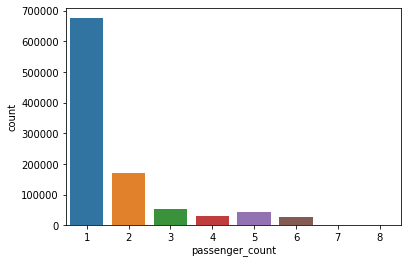

In [38]:
sns.countplot(x="passenger_count", data=taxiSample)

In [39]:
taxiSample.groupby('passenger_count')['passenger_count'].count()

passenger_count
1    674980
2    171178
3     54857
4     31747
5     44704
6     27373
7         1
8         2
Name: passenger_count, dtype: int64

### What is the percentage of store and forward trip?

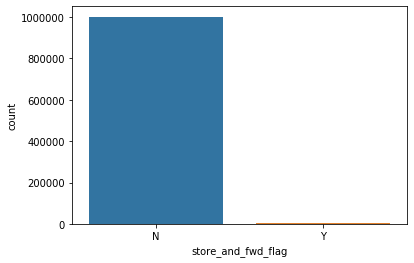

In [40]:
sns.countplot(x="store_and_fwd_flag", data=taxiSample)

In [41]:
taxiSample.groupby('store_and_fwd_flag')['store_and_fwd_flag'].count()

store_and_fwd_flag
N    1001247
Y       3595
Name: store_and_fwd_flag, dtype: int64

In [42]:
temp_flag = taxiSample[taxiSample.store_and_fwd_flag=='N']
(temp_flag.shape[0]*100) / taxiSample.shape[0]  # percentage of record that are N

99.64223231114941

### What is the most popular payment method?

payment_type is a numeric code signifying how the passenger paid for the trip:

* 1=Credit card
* 2=Cash
* 3=No charge
* 4=Dispute

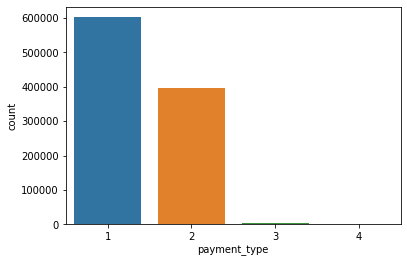

In [43]:
sns.countplot(x="payment_type", data=taxiSample)

In [44]:
taxiSample.groupby('payment_type')['payment_type'].count()

payment_type
1    602108
2    397374
3      3928
4      1432
Name: payment_type, dtype: int64

### What is the rate of tip?

In [45]:
no_tip = taxiSample[taxiSample.tip_amount==0]
no_tip.shape

(435176, 25)

In [46]:
tip = taxiSample[taxiSample.tip_amount>0]
tip.shape

(569666, 25)

In [47]:
(tip.shape[0]*100) / (no_tip.shape[0] + tip.shape[0])  # percentage of passenger that tips

56.69209686697013

### Which day of the week has most pickup/dropoff?

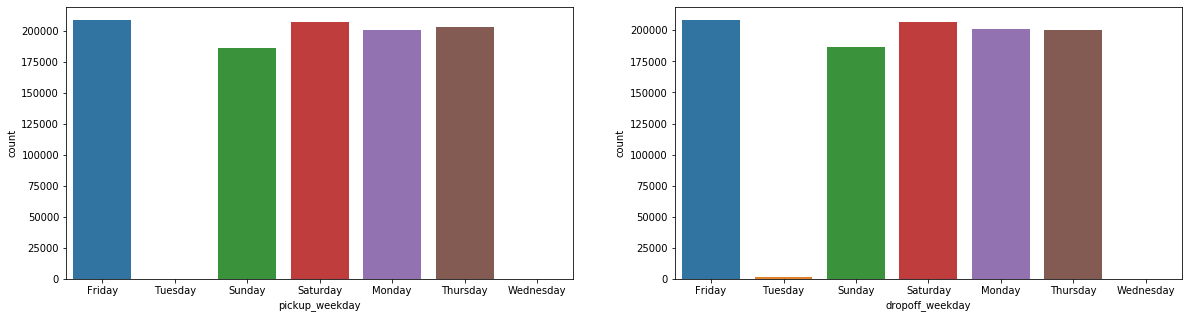

In [48]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.countplot(x="pickup_weekday", data=taxiSample, ax=ax[0])
sns.countplot(x="dropoff_weekday", data=taxiSample, ax=ax[1])
plt.show()

### Which time of the day has most pickup/dropoff?

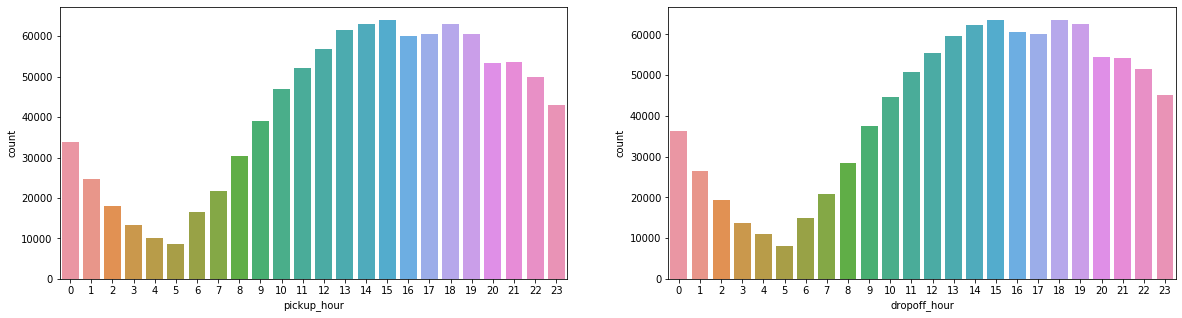

In [49]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.countplot(x="pickup_hour", data=taxiSample, ax=ax[0])
sns.countplot(x="dropoff_hour", data=taxiSample, ax=ax[1])
plt.show()

### Which month has the most pickup/dropoff?

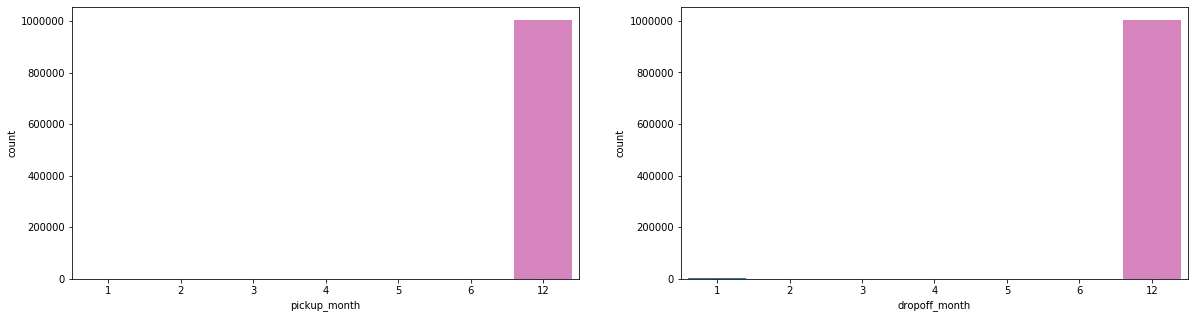

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.countplot(x="pickup_month", data=taxiSample, ax=ax[0])
sns.countplot(x="dropoff_month", data=taxiSample, ax=ax[1])
plt.show()

### Insights related to trip duration

In [51]:
taxiSample['trip_duration'] = (taxiSample.tpep_dropoff_datetime - taxiSample.tpep_pickup_datetime).dt.total_seconds()

In [52]:
taxiSample.trip_duration.describe()

count    1.004842e+06
mean     1.111986e+03
std      4.972414e+03
min      1.000000e+00
25%      3.720000e+02
50%      6.420000e+02
75%      1.081000e+03
max      8.639400e+04
Name: trip_duration, dtype: float64

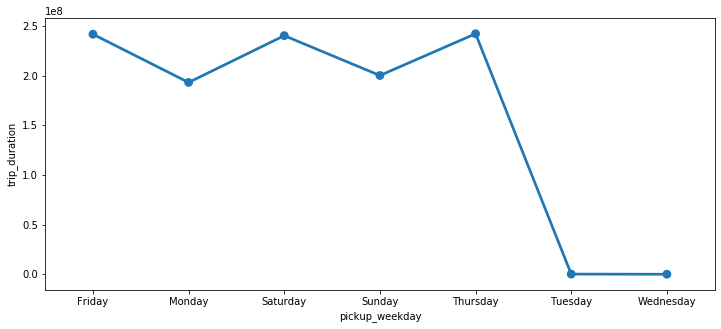

In [53]:
df_train_agg = taxiSample.groupby('pickup_weekday')['trip_duration'].sum().reset_index()
plt.figure(figsize=(12,5))
sns.pointplot(df_train_agg.pickup_weekday, df_train_agg.trip_duration)
plt.show()

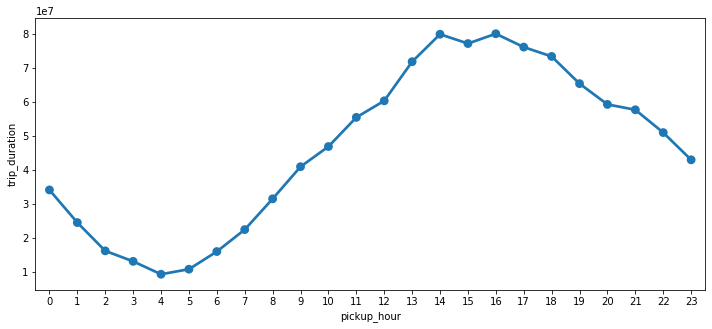

In [54]:
df_train_agg = taxiSample.groupby('pickup_hour')['trip_duration'].sum().reset_index()
plt.figure(figsize=(12,5))
sns.pointplot(df_train_agg.pickup_hour, df_train_agg.trip_duration)
plt.show()

### Insights related to trip distance

In [55]:
taxiSample['trip_distance'].describe()

count    1.004842e+06
mean     3.036813e+00
std      3.892059e+00
min      1.000000e-02
25%      9.700000e-01
50%      1.640000e+00
75%      3.120000e+00
max      9.117000e+01
Name: trip_distance, dtype: float64

In [56]:
short_distance = taxiSample[taxiSample.trip_distance<20.0]
long_distance = taxiSample[taxiSample.trip_distance>=20.0]
print(short_distance.shape)
print(long_distance.shape)

(997213, 26)
(7629, 26)


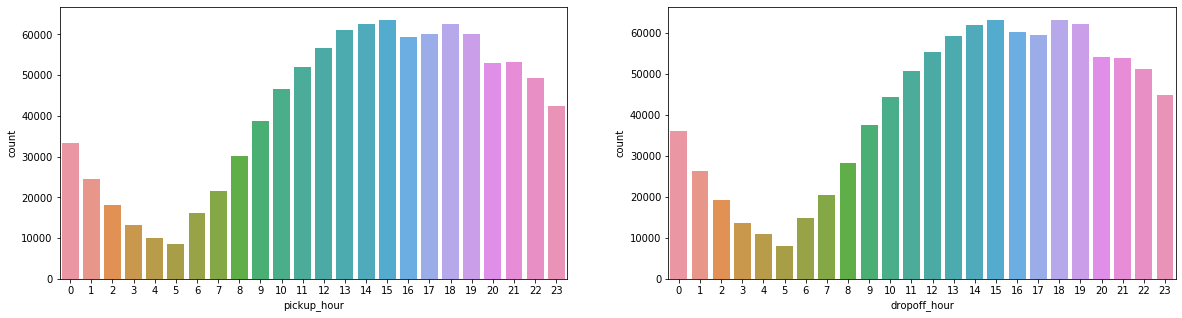

In [57]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.countplot(x="pickup_hour", data=short_distance, ax=ax[0])
sns.countplot(x="dropoff_hour", data=short_distance, ax=ax[1])
plt.show()

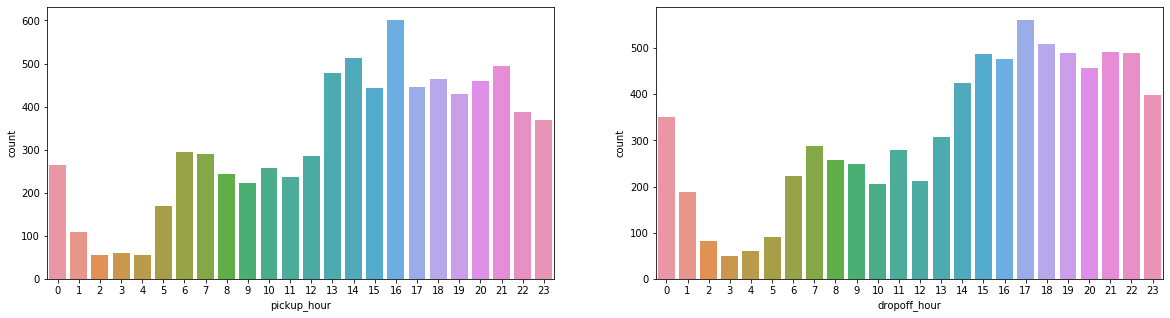

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.countplot(x="pickup_hour", data=long_distance, ax=ax[0])
sns.countplot(x="dropoff_hour", data=long_distance, ax=ax[1])
plt.show()

### Traffic condition in a day

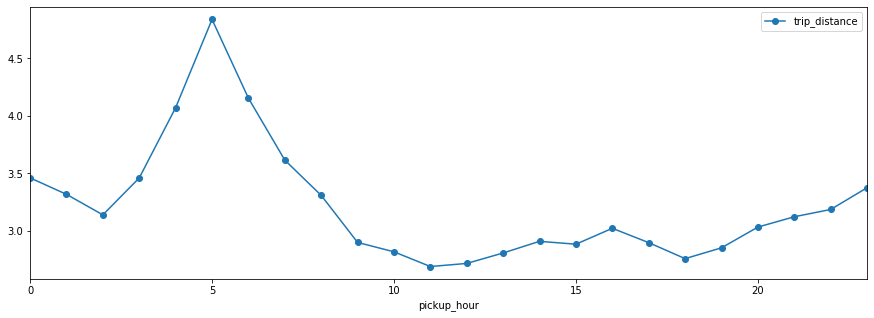

In [59]:
traffic = taxiSample.groupby('pickup_hour')['trip_distance','trip_duration'].mean().reset_index()
ax = traffic.plot(x='pickup_hour', y='trip_distance', kind='line', style="-o", figsize=(15,5))
plt.show()

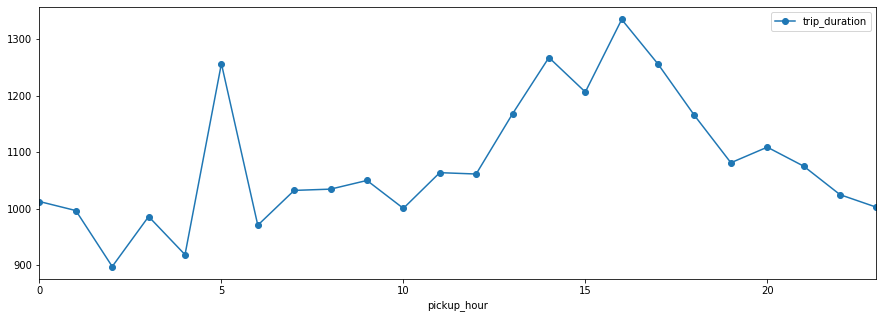

In [60]:
ax = traffic.plot(x='pickup_hour', y=['trip_duration'], kind='line', style="-o", figsize=(15,5))
plt.show()

## Loading shape file to display borough and zones

In [61]:
taxiZones = shapefile.Reader("data/taxi_zones/taxi_zones.shp")
fields_name = [field[0] for field in taxiZones.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))

attributes = taxiZones.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]
print(shp_attr[:2])

[{'OBJECTID': 1, 'Shape_Leng': 0.116357453189, 'Shape_Area': 0.0007823067885, 'zone': 'Newark Airport', 'LocationID': 1, 'borough': 'EWR'}, {'OBJECTID': 2, 'Shape_Leng': 0.43346966679, 'Shape_Area': 0.00486634037837, 'zone': 'Jamaica Bay', 'LocationID': 2, 'borough': 'Queens'}]


In [62]:
def get_lat_lon(taxiZones):
    content = []
    for sr in taxiZones.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])

In [63]:
df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(taxiZones).set_index("LocationID"), on="LocationID")
zone_dic = dict(zip(df_loc.LocationID, df_loc.zone))
borough_dic = dict(zip(df_loc.LocationID, df_loc.borough))
df_loc.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,9.366817e+05,190522.130278
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,1.033536e+06,161853.982300
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,1.027136e+06,254730.010849
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,9.904240e+05,203100.040432
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,9.321332e+05,139954.541936


In [64]:
boroughs = df_loc['borough'].unique()
print(boroughs)

['EWR' 'Queens' 'Bronx' 'Manhattan' 'Staten Island' 'Brooklyn']


In [65]:
def get_boundaries(sf):
    lat, lon = [], []
    for shape in list(sf.iterShapes()):
        lat.extend([shape.bbox[0], shape.bbox[2]])
        lon.extend([shape.bbox[1], shape.bbox[3]])

    margin = 0.01 # buffer to add to the range
    lat_min = min(lat) - margin
    lat_max = max(lat) + margin
    lon_min = min(lon) - margin
    lon_max = max(lon) + margin

    return lat_min, lat_max, lon_min, lon_max

In [66]:
def draw_region_map(ax, taxiZones, heat={}):
    continent = [235/256, 151/256, 78/256]
    ocean = (89/256, 171/256, 227/256)    
    
    reg_list={'EWR':1, 'Queens':2, 'Bronx':3, 'Manhattan':4, 'Staten Island':5, 'Brooklyn':6}
    reg_x = {'EWR':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'Staten Island':[], 'Brooklyn':[]}
    reg_y = {'EWR':[], 'Queens':[], 'Bronx':[], 'Manhattan':[], 'Staten Island':[], 'Brooklyn':[]}
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=math.sqrt(min(heat.values())), vmax=math.sqrt(max(heat.values())))
        cm=plt.get_cmap('Reds')
    
    ax.set_facecolor(ocean)
    for sr in taxiZones.shapeRecords():
        shape = sr.shape
        rec = sr.record
        reg_name = rec[shp_dic['borough']]
        
        if len(heat) == 0:
            norm = mpl.colors.Normalize(vmin=1,vmax=6) #norm = mpl.colors.LogNorm(vmin=1,vmax=max(heat))
            cm=plt.get_cmap('Pastel1')
            R,G,B,A = cm(norm(reg_list[reg_name]))
            col = [R,G,B]
        else:
            R,G,B,A = cm(norm(math.sqrt(heat[reg_name])))
            col = [R,G,B]
            
        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
                
        reg_x[reg_name].append((shape.bbox[0]+shape.bbox[2])/2)
        reg_y[reg_name].append((shape.bbox[1]+shape.bbox[3])/2)
        
    for k in reg_list:
        if len(heat)==0:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), k, horizontalalignment='center',
                     verticalalignment='center', bbox=dict(facecolor='black', alpha=0.5),
                     color="white", fontsize=12)     
        else:
            plt.text(np.mean(reg_x[k]), np.mean(reg_y[k]), "{}\n({}K)".format(k, heat[k]/1000),
                     horizontalalignment='center', verticalalignment='center',
                     bbox=dict(facecolor='black', alpha=0.7), color="white", fontsize=12)       

    # display
    limits = get_boundaries(taxiZones)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

In [67]:
def draw_zone_map(ax, taxiZones, heat={}, text=[], arrows=[]):
    continent = [180/256, 50/256, 50/256]
    ocean = (89/256, 171/256, 227/256)
    theta = np.linspace(0, 2*np.pi, len(text)+1).tolist()
    ax.set_facecolor(ocean)
    
    # colorbar
    if len(heat) != 0:
        norm = mpl.colors.Normalize(vmin=min(heat.values()),vmax=max(heat.values()))
        cm=plt.get_cmap('Reds')
        sm = plt.cm.ScalarMappable(cmap=cm, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ticks=np.linspace(min(heat.values()),max(heat.values()),8),
                     boundaries=np.arange(min(heat.values())-10,max(heat.values())+10,.1))
    
    for sr in taxiZones.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        zone = rec[shp_dic['zone']]
        
        if len(heat) == 0:
            col = continent
        else:
            if loc_id not in heat:
                R,G,B,A = cm(norm(0))
            else:
                R,G,B,A = cm(norm(heat[loc_id]))
            col = [R,G,B]

        # check number of parts (could use MultiPolygon class of shapely?)
        nparts = len(shape.parts) # total parts
        if nparts == 1:
            polygon = Polygon(shape.points)
            patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
            ax.add_patch(patch)
        else: # loop over parts of each shape, plot separately
            for ip in range(nparts): # loop over parts, plot separately
                i0 = shape.parts[ip]
                if ip < nparts-1:
                    i1 = shape.parts[ip+1]-1
                else:
                    i1 = len(shape.points)

                polygon = Polygon(shape.points[i0:i1+1])
                patch = PolygonPatch(polygon, facecolor=col, alpha=1.0, zorder=2)
                ax.add_patch(patch)
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        if (len(text) == 0 and rec[shp_dic['Shape_Area']] > 0.0001):
            plt.text(x, y, str(loc_id), horizontalalignment='center', verticalalignment='center')            
        elif len(text) != 0 and loc_id in text:
            eta_x = 0.05*np.cos(theta[text.index(loc_id)])
            eta_y = 0.05*np.sin(theta[text.index(loc_id)])
            ax.annotate("[{}] {}".format(loc_id, zone), xy=(x, y), xytext=(x+eta_x, y+eta_y),
                        bbox=dict(facecolor='black', alpha=0.7), color="white", fontsize=8,
                        arrowprops=dict(facecolor='black', width=3, shrink=0.05))
    if len(arrows)!=0:
        for arr in arrows:
            ax.annotate('', xy = arr['dest'], xytext = arr['src'], size = arr['cnt'],
                    arrowprops=dict(arrowstyle="fancy", fc="0.6", ec="none"))
    
    # display
    limits = get_boundaries(taxiZones)
    plt.xlim(limits[0], limits[1])
    plt.ylim(limits[2], limits[3])

### Show the borough and zones of New York City

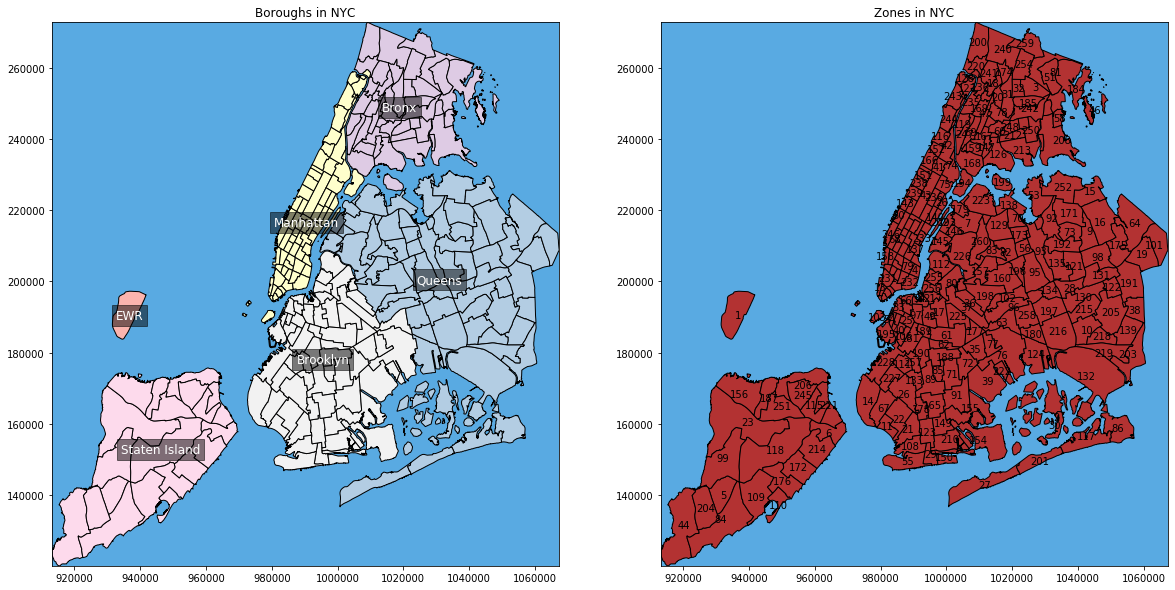

In [68]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs in NYC")
draw_region_map(ax, taxiZones)
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones in NYC")
draw_zone_map(ax, taxiZones)

### Show the top 5 zones with most pickups and dropoffs

In [69]:
pu_location = taxiSample.groupby('PULocationID')['PULocationID'].count().reset_index(name='puCount').rename(columns={'PULocationID':'LocationID'})
do_location = taxiSample.groupby('DOLocationID')['DOLocationID'].count().reset_index(name='doCount').rename(columns={'DOLocationID':'LocationID'})

In [70]:
pu_do_location = df_loc.merge(pu_location, on='LocationID', how='left')
pu_do_location = pu_do_location.merge(do_location, on='LocationID', how='left')
pu_do_location['totalCount'] = pu_do_location['puCount'] + pu_do_location['doCount']
pu_do_location.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude,puCount,doCount,totalCount
0,1,0.116357,0.000782,Newark Airport,1,EWR,9.366817e+05,190522.130278,26.0,1473.0,1499.0
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,1.033536e+06,161853.982300,1.0,1.0,2.0
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,1.027136e+06,254730.010849,27.0,89.0,116.0
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,9.904240e+05,203100.040432,2221.0,5443.0,7664.0
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,9.321332e+05,139954.541936,1.0,7.0,8.0


In [71]:
puCount = dict(zip(pu_do_location['LocationID'].tolist(), pu_do_location['puCount'].tolist()))
puTop5 = pu_do_location.sort_values(by=['puCount'], ascending=False).set_index("LocationID").head(5)
doCount = dict(zip(pu_do_location['LocationID'].tolist(), pu_do_location['doCount'].tolist()))
doTop5 = pu_do_location.sort_values(by=['doCount'], ascending=False).set_index("LocationID").head(5)

In [72]:
puTop5

,OBJECTID,Shape_Leng,Shape_Area,zone,borough,longitude,latitude,puCount,doCount,totalCount
LocationID,,,,,,,,,,
186,186,0.024696,0.000037,Penn Station/Madison Sq West,Manhattan,986346.343415,211974.157667,42281.0,27958.0,70239.0
48,48,0.043747,0.000094,Clinton East,Manhattan,987065.467994,216984.693458,38015.0,33968.0,71983.0
237,237,0.042213,0.000096,Upper East Side South,Manhattan,993768.783313,219305.448647,36698.0,32673.0,69371.0
161,161,0.035804,0.000072,Midtown Center,Manhattan,990433.407940,215448.355221,36244.0,36966.0,73210.0
162,162,0.035270,0.000048,Midtown East,Manhattan,991876.747966,215015.150630,33173.0,28972.0,62145.0


In [73]:
doTop5

,OBJECTID,Shape_Leng,Shape_Area,zone,borough,longitude,latitude,puCount,doCount,totalCount
LocationID,,,,,,,,,,
161,161,0.035804,0.000072,Midtown Center,Manhattan,990433.407940,215448.355221,36244.0,36966.0,73210.0
48,48,0.043747,0.000094,Clinton East,Manhattan,987065.467994,216984.693458,38015.0,33968.0,71983.0
236,236,0.044252,0.000103,Upper East Side North,Manhattan,996155.897922,223614.973989,32533.0,33856.0,66389.0
237,237,0.042213,0.000096,Upper East Side South,Manhattan,993768.783313,219305.448647,36698.0,32673.0,69371.0
170,170,0.045769,0.000074,Murray Hill,Manhattan,990443.335463,211693.748324,30165.0,30042.0,60207.0


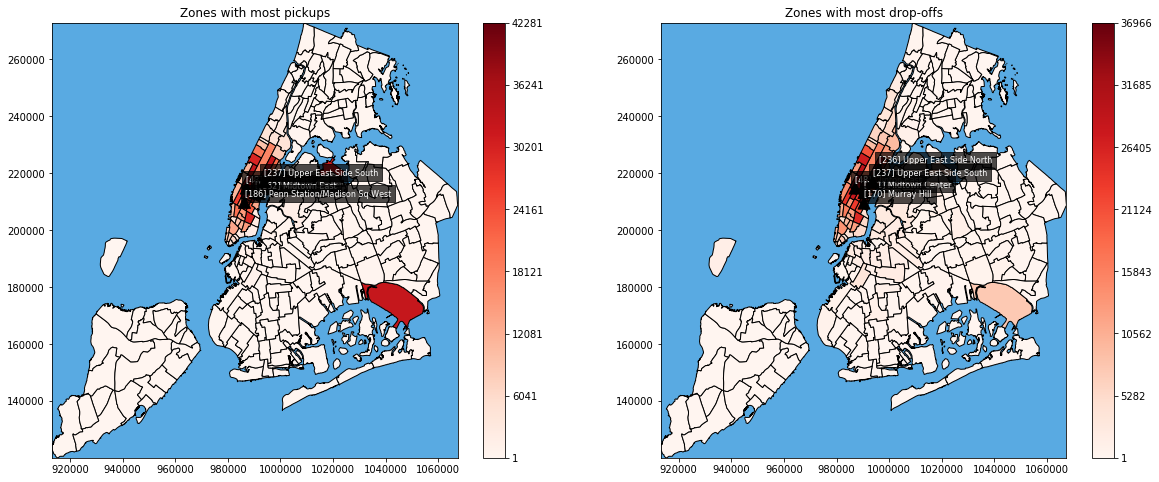

In [74]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Zones with most pickups")
draw_zone_map(ax, taxiZones, heat=puCount, text=puTop5.index.tolist())
ax = plt.subplot(1, 2, 2)
ax.set_title("Zones with most drop-offs")
draw_zone_map(ax, taxiZones, heat=doCount, text=doTop5.index.tolist())

### Which region has the most pickups and dropoffs?

In [75]:
pu_do_region = pu_do_location.groupby('borough')[['puCount','doCount','totalCount']].sum().reset_index().sort_values(by='totalCount', ascending=False)
pu_do_region

,borough,puCount,doCount,totalCount
3,Manhattan,914271.0,896686.0,1810957.0
4,Queens,75771.0,50454.0,126207.0
1,Brooklyn,12779.0,47898.0,60677.0
0,Bronx,2210.0,9159.0,11342.0
2,EWR,26.0,1473.0,1499.0
5,Staten Island,50.0,273.0,287.0


In [76]:
poCount = dict(zip(pu_do_region['borough'].tolist(), pu_do_region['puCount'].tolist()))
doCount = dict(zip(pu_do_region['borough'].tolist(), pu_do_region['doCount'].tolist()))

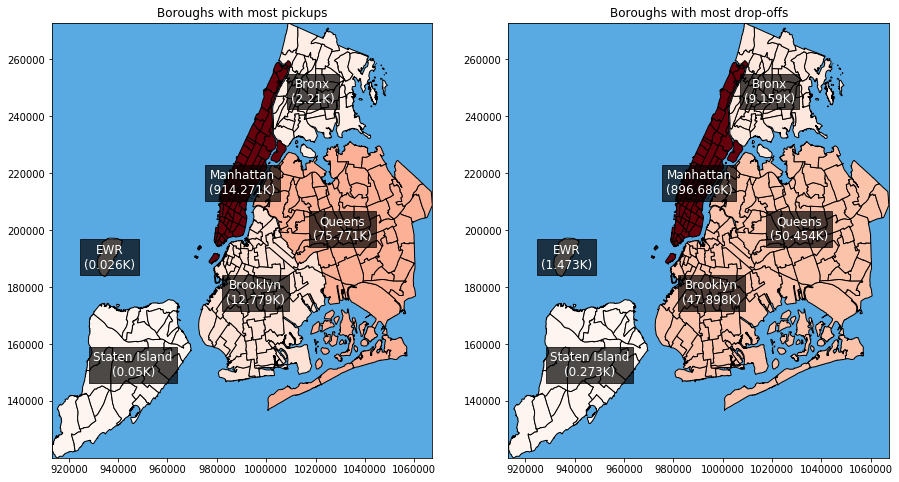

In [77]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs with most pickups")
draw_region_map(ax, taxiZones, heat = poCount)
ax = plt.subplot(1, 2, 2)
ax.set_title("Boroughs with most drop-offs")
draw_region_map(ax, taxiZones, heat = doCount)

### Which zone has the most pickups/dropoffs for short trips (distance<20)
### Which zone has the most pickups/dropoffs for long trips (distance>=20)

In [78]:
pu_location_short = taxiSample[taxiSample.trip_distance<20].groupby('PULocationID')['PULocationID'].count().reset_index(name='puCount').rename(columns={'PULocationID':'LocationID'})
do_location_short = taxiSample[taxiSample.trip_distance<20].groupby('DOLocationID')['DOLocationID'].count().reset_index(name='doCount').rename(columns={'DOLocationID':'LocationID'})

pu_do_location_short = df_loc.merge(pu_location_short, on='LocationID', how='left')
pu_do_location_short = pu_do_location_short.merge(do_location_short, on='LocationID', how='left')
pu_do_location_short['totalCount'] = pu_do_location_short['puCount'] + pu_do_location_short['doCount']

In [79]:
pu_location_long = taxiSample[taxiSample.trip_distance>=20].groupby('PULocationID')['PULocationID'].count().reset_index(name='puCount').rename(columns={'PULocationID':'LocationID'})
do_location_long = taxiSample[taxiSample.trip_distance>=20].groupby('DOLocationID')['DOLocationID'].count().reset_index(name='doCount').rename(columns={'DOLocationID':'LocationID'})

pu_do_location_long = df_loc.merge(pu_location_long, on='LocationID', how='left')
pu_do_location_long = pu_do_location_long.merge(do_location_long, on='LocationID', how='left')
pu_do_location_long['totalCount'] = pu_do_location_long['puCount'] + pu_do_location_long['doCount']

In [80]:
puCountShort = dict(zip(pu_do_location_short['LocationID'].tolist(), pu_do_location_short['puCount'].tolist()))
puTop5Short = pu_do_location_short.sort_values(by=['puCount'], ascending=False).set_index("LocationID").head(5)
doCountShort = dict(zip(pu_do_location_short['LocationID'].tolist(), pu_do_location_short['doCount'].tolist()))
doTop5Short = pu_do_location_short.sort_values(by=['doCount'], ascending=False).set_index("LocationID").head(5)

In [81]:
puTop5Short

,OBJECTID,Shape_Leng,Shape_Area,zone,borough,longitude,latitude,puCount,doCount,totalCount
LocationID,,,,,,,,,,
186,186,0.024696,0.000037,Penn Station/Madison Sq West,Manhattan,986346.343415,211974.157667,42254.0,27944.0,70198.0
48,48,0.043747,0.000094,Clinton East,Manhattan,987065.467994,216984.693458,37927.0,33878.0,71805.0
237,237,0.042213,0.000096,Upper East Side South,Manhattan,993768.783313,219305.448647,36663.0,32582.0,69245.0
161,161,0.035804,0.000072,Midtown Center,Manhattan,990433.407940,215448.355221,36191.0,36926.0,73117.0
162,162,0.035270,0.000048,Midtown East,Manhattan,991876.747966,215015.150630,33138.0,28920.0,62058.0


In [82]:
doTop5Short

,OBJECTID,Shape_Leng,Shape_Area,zone,borough,longitude,latitude,puCount,doCount,totalCount
LocationID,,,,,,,,,,
161,161,0.035804,0.000072,Midtown Center,Manhattan,990433.407940,215448.355221,36191.0,36926.0,73117.0
48,48,0.043747,0.000094,Clinton East,Manhattan,987065.467994,216984.693458,37927.0,33878.0,71805.0
236,236,0.044252,0.000103,Upper East Side North,Manhattan,996155.897922,223614.973989,32494.0,33810.0,66304.0
237,237,0.042213,0.000096,Upper East Side South,Manhattan,993768.783313,219305.448647,36663.0,32582.0,69245.0
170,170,0.045769,0.000074,Murray Hill,Manhattan,990443.335463,211693.748324,30142.0,30033.0,60175.0


In [83]:
puCountLong = dict(zip(pu_do_location_long['LocationID'].tolist(), pu_do_location_long['puCount'].tolist()))
puTop5Long = pu_do_location_long.sort_values(by=['puCount'], ascending=False).set_index("LocationID").head(5)
doCountLong = dict(zip(pu_do_location_long['LocationID'].tolist(), pu_do_location_long['doCount'].tolist()))
doTop5Long = pu_do_location_long.sort_values(by=['doCount'], ascending=False).set_index("LocationID").head(5)

In [84]:
puTop5Long

,OBJECTID,Shape_Leng,Shape_Area,zone,borough,longitude,latitude,puCount,doCount,totalCount
LocationID,,,,,,,,,,
132,132,0.245479,0.002038,JFK Airport,Queens,1.042628e+06,173494.353508,5440.0,877.0,6317.0
239,239,0.063626,0.000205,Upper West Side South,Manhattan,9.901399e+05,224918.916683,140.0,393.0,533.0
142,142,0.038176,0.000076,Lincoln Square East,Manhattan,9.893656e+05,221142.058374,104.0,253.0,357.0
138,138,0.107467,0.000537,LaGuardia Airport,Queens,1.019304e+06,221604.395797,98.0,17.0,115.0
13,13,0.050281,0.000149,Battery Park City,Manhattan,9.798442e+05,198508.159318,90.0,203.0,293.0


In [85]:
doTop5Long

,OBJECTID,Shape_Leng,Shape_Area,zone,borough,longitude,latitude,puCount,doCount,totalCount
LocationID,,,,,,,,,,
132,132,0.245479,0.002038,JFK Airport,Queens,1.042628e+06,173494.353508,5440.0,877.0,6317.0
239,239,0.063626,0.000205,Upper West Side South,Manhattan,9.901399e+05,224918.916683,140.0,393.0,533.0
238,238,0.060109,0.000185,Upper West Side North,Manhattan,9.917176e+05,227746.100420,67.0,360.0,427.0
1,1,0.116357,0.000782,Newark Airport,EWR,9.366817e+05,190522.130278,2.0,282.0,284.0
87,87,0.036902,0.000067,Financial District North,Manhattan,9.822430e+05,196731.423073,48.0,273.0,321.0


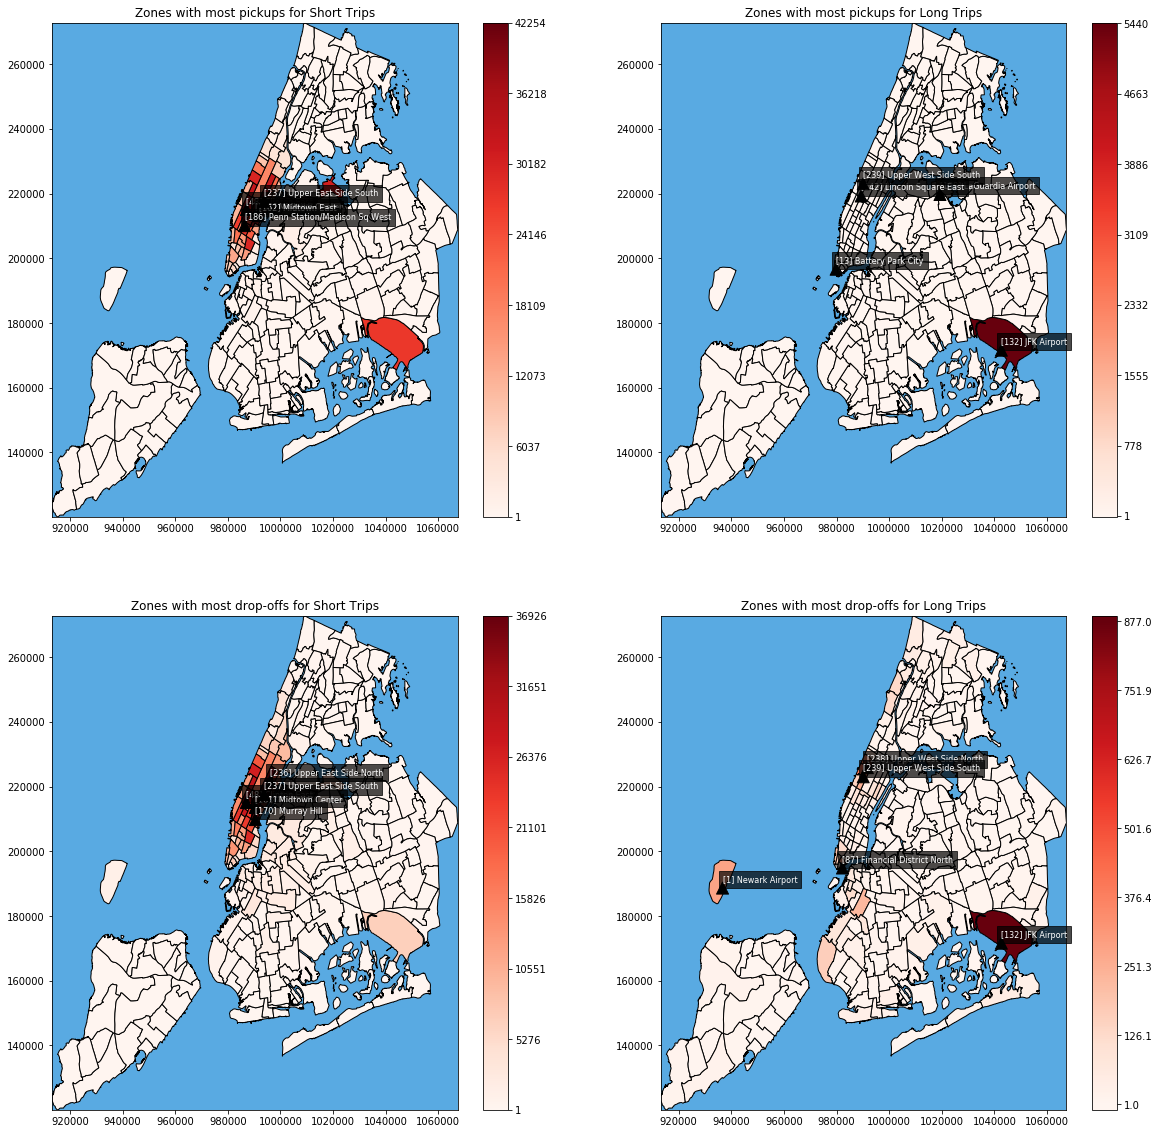

In [86]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,20))
ax = plt.subplot(2, 2, 1)
ax.set_title("Zones with most pickups for Short Trips")
draw_zone_map(ax, taxiZones, heat=puCountShort, text=puTop5Short.index.tolist())
ax = plt.subplot(2, 2, 2)
ax.set_title("Zones with most pickups for Long Trips")
draw_zone_map(ax, taxiZones, heat=puCountLong, text=puTop5Long.index.tolist())
ax = plt.subplot(2, 2, 3)
ax.set_title("Zones with most drop-offs for Short Trips")
draw_zone_map(ax, taxiZones, heat=doCountShort, text=doTop5Short.index.tolist())
ax = plt.subplot(2, 2, 4)
ax.set_title("Zones with most drop-offs for Long Trips")
draw_zone_map(ax, taxiZones, heat=doCountLong, text=doTop5Long.index.tolist())

### Which region is popular for short trips?
### Which region is popular for long trips?

In [87]:
pu_do_region_short = pu_do_location_short.groupby('borough')[['puCount','doCount','totalCount']].sum().reset_index().sort_values(by='totalCount', ascending=False)
pu_do_region_short

,borough,puCount,doCount,totalCount
3,Manhattan,912637.0,892692.0,1805329.0
4,Queens,70079.0,49246.0,119308.0
1,Brooklyn,12581.0,46382.0,58963.0
0,Bronx,2119.0,8674.0,10745.0
2,EWR,24.0,1191.0,1215.0
5,Staten Island,38.0,126.0,139.0


In [88]:
pu_do_region_long = pu_do_location_long.groupby('borough')[['puCount','doCount','totalCount']].sum().reset_index().sort_values(by='totalCount', ascending=False)
pu_do_region_long

,borough,puCount,doCount,totalCount
4,Queens,5692.0,1208.0,6868.0
3,Manhattan,1634.0,3994.0,5621.0
1,Brooklyn,198.0,1516.0,1594.0
0,Bronx,91.0,485.0,462.0
2,EWR,2.0,282.0,284.0
5,Staten Island,12.0,147.0,78.0


In [89]:
totalCountShort = dict(zip(pu_do_region_short['borough'].tolist(), pu_do_region_short['totalCount'].tolist()))
totalCountLong = dict(zip(pu_do_region_long['borough'].tolist(), pu_do_region_long['totalCount'].tolist()))

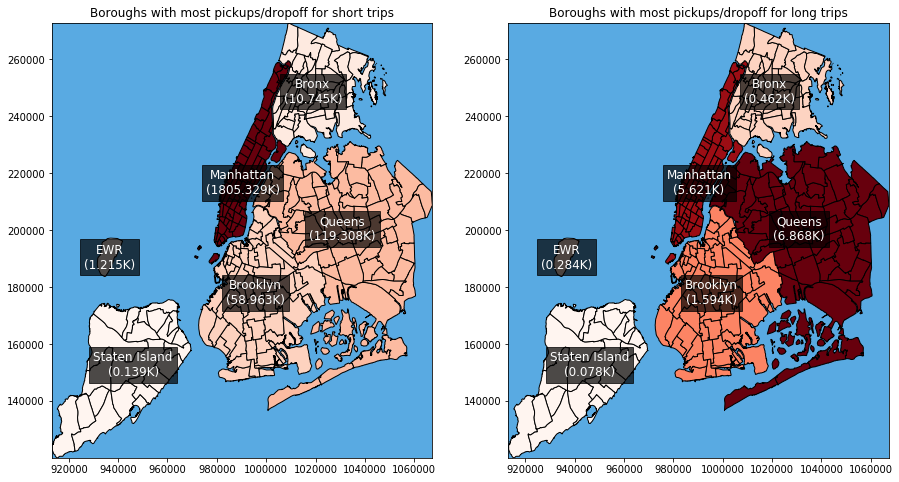

In [90]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("Boroughs with most pickups/dropoff for short trips")
draw_region_map(ax, taxiZones, heat = totalCountShort)
ax = plt.subplot(1, 2, 2)
ax.set_title("Boroughs with most pickups/dropoff for long trips")
draw_region_map(ax, taxiZones, heat = totalCountLong)

### Show top 5 zones, which has the most intra zone trip

In [91]:
intraZone = taxiSample[taxiSample.PULocationID == taxiSample.DOLocationID].groupby('PULocationID')['PULocationID'].count().reset_index(name='count').rename(columns={'PULocationID':'LocationID'}).sort_values(by='count', ascending=False).head(5)
intraZone = intraZone.merge(df_loc, on='LocationID', how='left')
intraZone

,LocationID,count,OBJECTID,Shape_Leng,Shape_Area,zone,borough,longitude,latitude
0,237,4097,237,0.042213,0.000096,Upper East Side South,Manhattan,993768.783313,219305.448647
1,236,4036,236,0.044252,0.000103,Upper East Side North,Manhattan,996155.897922,223614.973989
2,48,2919,48,0.043747,0.000094,Clinton East,Manhattan,987065.467994,216984.693458
3,239,2569,239,0.063626,0.000205,Upper West Side South,Manhattan,990139.871381,224918.916683
4,79,2346,79,0.042625,0.000108,East Village,Manhattan,988320.124716,204490.058251


In [92]:
countList = dict(zip(intraZone['LocationID'].tolist(), intraZone['count'].tolist()))

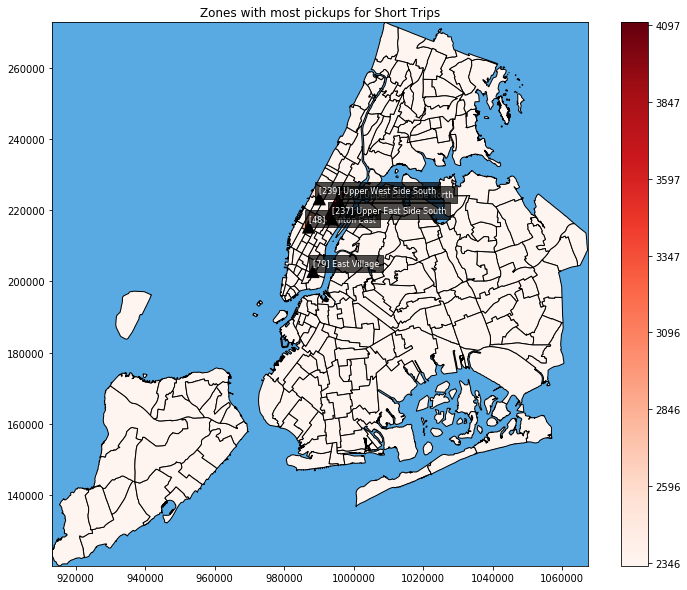

In [93]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,10))
ax = plt.subplot(1, 1, 1)
ax.set_title("Zones with most pickups for Short Trips")
draw_zone_map(ax, taxiZones, heat=countList, text=intraZone.LocationID.tolist())

### Show top 5 short distance trip

In [94]:
top5Short = taxiSample[taxiSample.trip_distance<20].groupby(['PULocationID','DOLocationID'])['PULocationID'].count().reset_index(name='count').sort_values(by='count', ascending=False).head(5)
puZones = []
puBoroughs = []
doZones = []
doBoroughs = []
for i, j in top5Short.iterrows():
    puZones.append(zone_dic[j[0]])
    puBoroughs.append(borough_dic[j[0]])
    doZones.append(zone_dic[j[1]])
    doBoroughs.append(borough_dic[j[1]])
top5Short['Pick-Up-Zone']=puZones
top5Short['Pick-Up-Borough']=puBoroughs
top5Short['Drop-Off-Zone']=doZones
top5Short['Drop-Off-Borough']=doBoroughs
top5Short

,PULocationID,DOLocationID,count,Pick-Up-Zone,Pick-Up-Borough,Drop-Off-Zone,Drop-Off-Borough
15729,237,236,4521,Upper East Side South,Manhattan,Upper East Side North,Manhattan
15730,237,237,4097,Upper East Side South,Manhattan,Upper East Side South,Manhattan
15543,236,236,4035,Upper East Side North,Manhattan,Upper East Side North,Manhattan
15544,236,237,3867,Upper East Side North,Manhattan,Upper East Side South,Manhattan
16004,239,142,3501,Upper West Side South,Manhattan,Lincoln Square East,Manhattan


### Show top 5 long distance trip

In [95]:
top5Long = taxiSample[taxiSample.trip_distance>=20].groupby(['PULocationID','DOLocationID'])['PULocationID'].count().reset_index(name='count').sort_values(by='count', ascending=False).head(5)
puZones = []
puBoroughs = []
doZones = []
doBoroughs = []
for i, j in top5Long.iterrows():
    puZones.append(zone_dic[j[0]])
    puBoroughs.append(borough_dic[j[0]])
    doZones.append(zone_dic[j[1]])
    doBoroughs.append(borough_dic[j[1]])
top5Long['Pick-Up-Zone']=puZones
top5Long['Pick-Up-Borough']=puBoroughs
top5Long['Drop-Off-Zone']=doZones
top5Long['Drop-Off-Borough']=doBoroughs
top5Long

,PULocationID,DOLocationID,count,Pick-Up-Zone,Pick-Up-Borough,Drop-Off-Zone,Drop-Off-Borough
567,132,239,389,JFK Airport,Queens,Upper West Side South,Manhattan
566,132,238,355,JFK Airport,Queens,Upper West Side North,Manhattan
464,132,87,271,JFK Airport,Queens,Financial District North,Manhattan
497,132,142,249,JFK Airport,Queens,Lincoln Square East,Manhattan
526,132,181,226,JFK Airport,Queens,Park Slope,Brooklyn


In [96]:
print("It took %s seconds to process" % (time.time() - startTime))

It took 39.69290614128113 seconds to process
